In [1]:
import rasterio as rio
import earthpy.spatial as es
import os, sys
from glob import glob
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
# stack, metadata = es.stack()

In [2]:
band_paths = glob(
    os.path.join(
        'LC09_L2SP_113037_20230510_20230512_02_T1',
        '*B*[0-9].TIF'
    )
)

# ...finds QA PIXEL band
qa_path = glob(
    os.path.join(
        'LC09_L2SP_113037_20230510_20230512_02_T1',
        "*QA_PIXEL.TIF"
    )
)

paths_to_crop = band_paths + qa_path

In [ ]:
### Stack uncropped data
stack, metadata = es.stack(band_paths, out_path = 'LC09_L2SP_113037_20230510_20230512_02_T1/Nagasaki_STACKED.tif')

In [ ]:
stack_mask = stack == 0
stack_masked = np.ma.masked_array(stack, mask = stack_mask)

stack_masked

In [3]:
def histogram_stretch(img, min_vals = None, max_vals = 99):
    """
    Performs a histogram_stretch on an image. DO NOT use this for analytical workflows - 
    this should only be used to improve image visualization
    
    img: an unmasked 3D raster 
    
    min_vals: percentile that you wish to crop to
        will be np.zeros by default
    max_vals: percentile that you wish to crop to
        will be np.nanpercentile(img, 99) by default # crops to 99th percentile
    """
    if img.ndim != 3:
        print("ValueError: Your raster must have three dimensions.")
        return
    
    # This returns the max_valth percentile
    max_vals = np.nanpercentile(img, max_vals, axis = (1,2)).reshape(img.shape[0],1,1) 
    # min_vals = np.nanmin(tcc_toa, axis = (1,2)).reshape(3,1,1) # Use this to stretch to minimum values
    if min_vals is not None:
        min_vals = np.nanpercentile(img, min_vals, axis = (1,2)).reshape(img.shape[0],1,1)
    else:
        min_vals = np.zeros(img.shape[0]).reshape(img.shape[0],1,1)
    
    # Perform normalization
    img_stretched = (img - min_vals) / (max_vals - min_vals)
    
    # Clip values above 1
    img_stretched[img_stretched > 1] = 1
    
    return img_stretched

In [4]:
with rio.open('LC09_L2SP_113037_20230510_20230512_02_T1/Nagasaki_STACKED.tif') as src:
    bounds = src.bounds
    profile = src.profile
    stack = src.read()
    src.close()

In [ ]:
scaled_stack = stack * 0.0000275 - 0.2

fig, ax = plt.subplots(figsize = (24,24))
show(histogram_stretch(scaled_stack[[3,2,1],...], 1, 99), ax = ax)
# show(scaled_stack[[3,2,1],...], ax = ax)

In [ ]:
metadata

In [ ]:
### for cropping
with rio.open('LC09_L2SP_113037_20230510_20230512_02_T1/Nagasaki_STACKED.tif') as src:
    bounds = src.bounds
    profile = src.profile
    src.close()
    
print(bounds)
print(profile)

CPU times: total: 11.8 s
Wall time: 14.7 s


<Axes: >

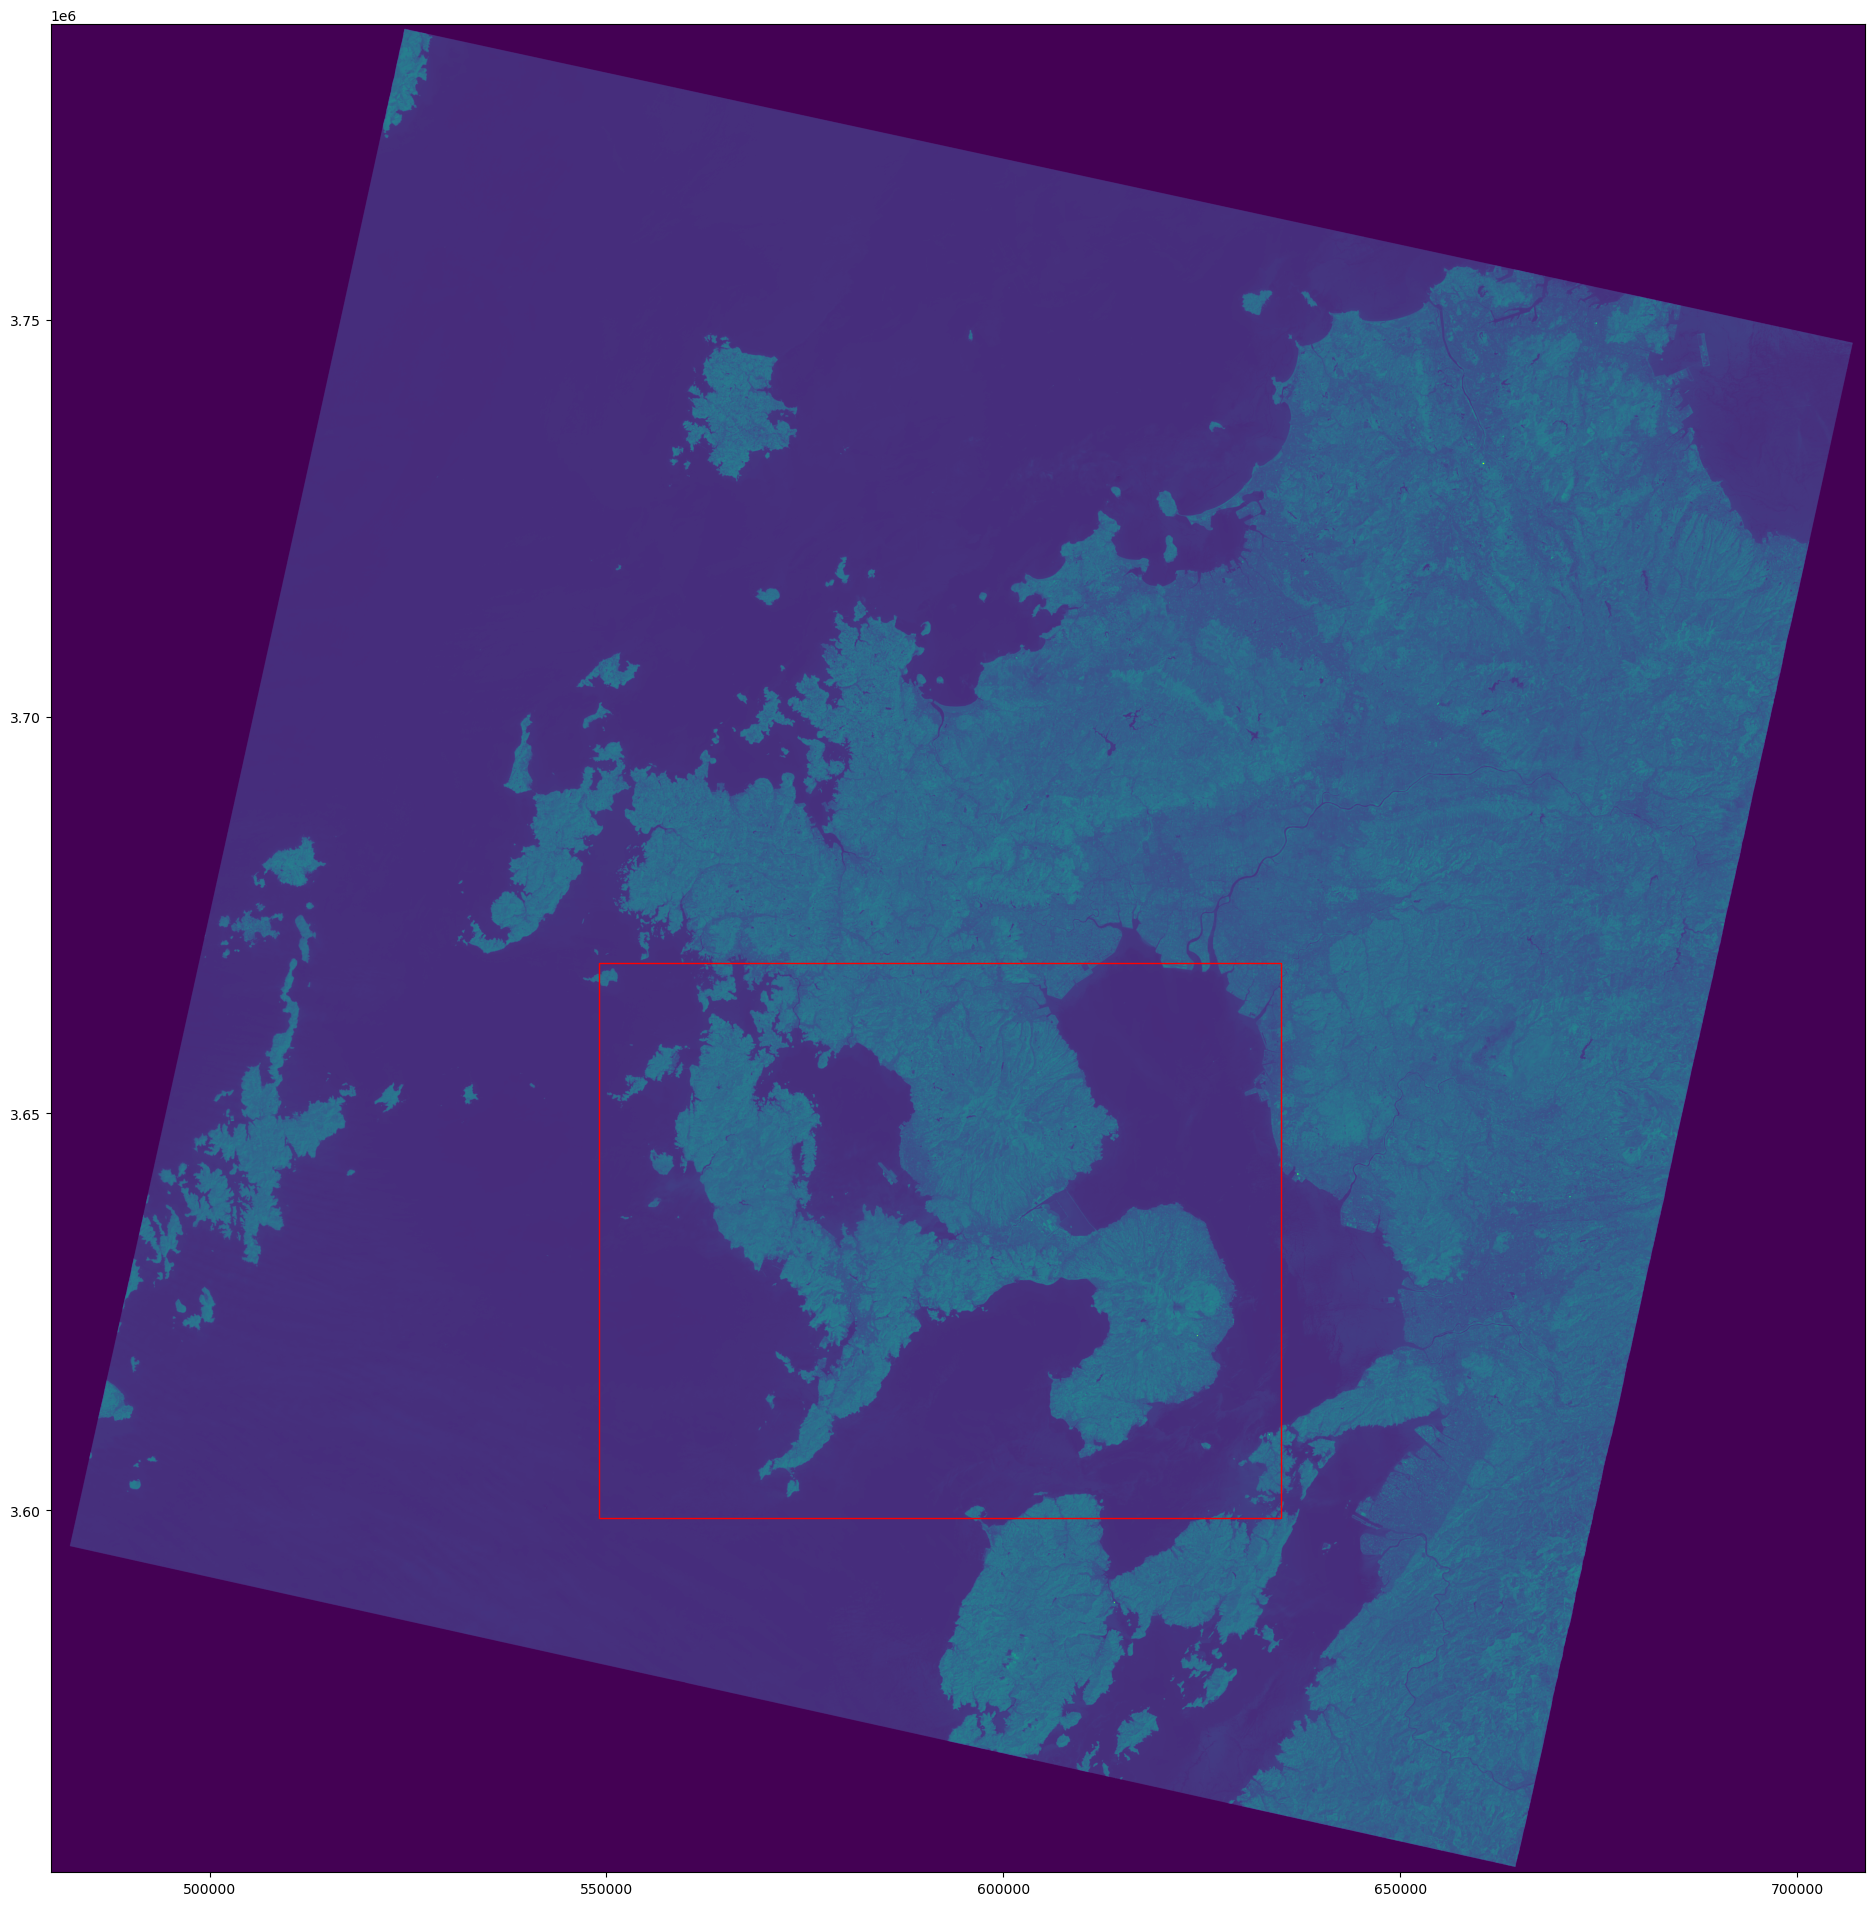

In [9]:
%%time
### Check extent of shapefile to ensure correct cropping extent
scaled_stack = stack * 0.0000275 - 0.2

target_shapefile = box(549000, 3599000, 635000, 3669000)

df = gpd.GeoDataFrame({"id":1,"geometry":[target_shapefile]})

fig, ax = plt.subplots(figsize = (24,24))
# remember to use transform argument to set the raster image to coordinates
show(scaled_stack[4], ax = ax, transform = profile['transform'])
df.plot(color = 'none', edgecolor = 'red', ax = ax)

In [10]:
### crop to study area
band_paths = es.crop_all(
    paths_to_crop, 'LC09_L2SP_113037_20230510_20230512_02_T1', [target_shapefile], overwrite=True
)

In [13]:
### Stack cropped data
stack, metadata = es.stack(band_paths[:-1], out_path = 'LC09_L2SP_113037_20230510_20230512_02_T1/Nagasaki_CROPPED_STACKED.tif')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

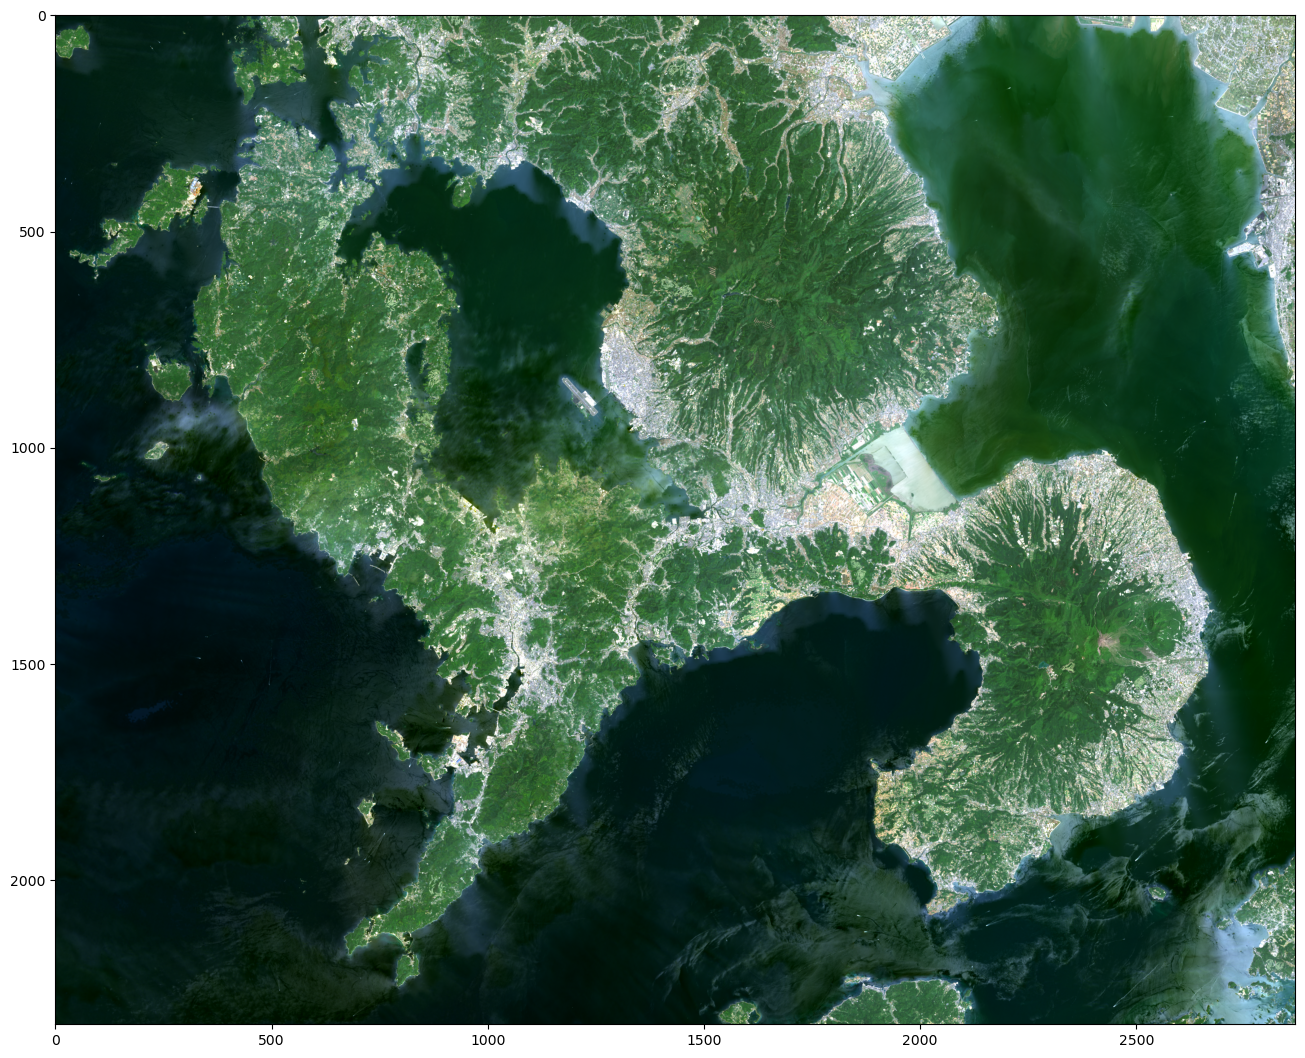

In [27]:
scaled_stack = stack * 0.0000275 - 0.2

fig, ax = plt.subplots(figsize = (16,16))
show(histogram_stretch(scaled_stack[[3,2,1],...]), ax = ax)

(<Figure size 1200x1200 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

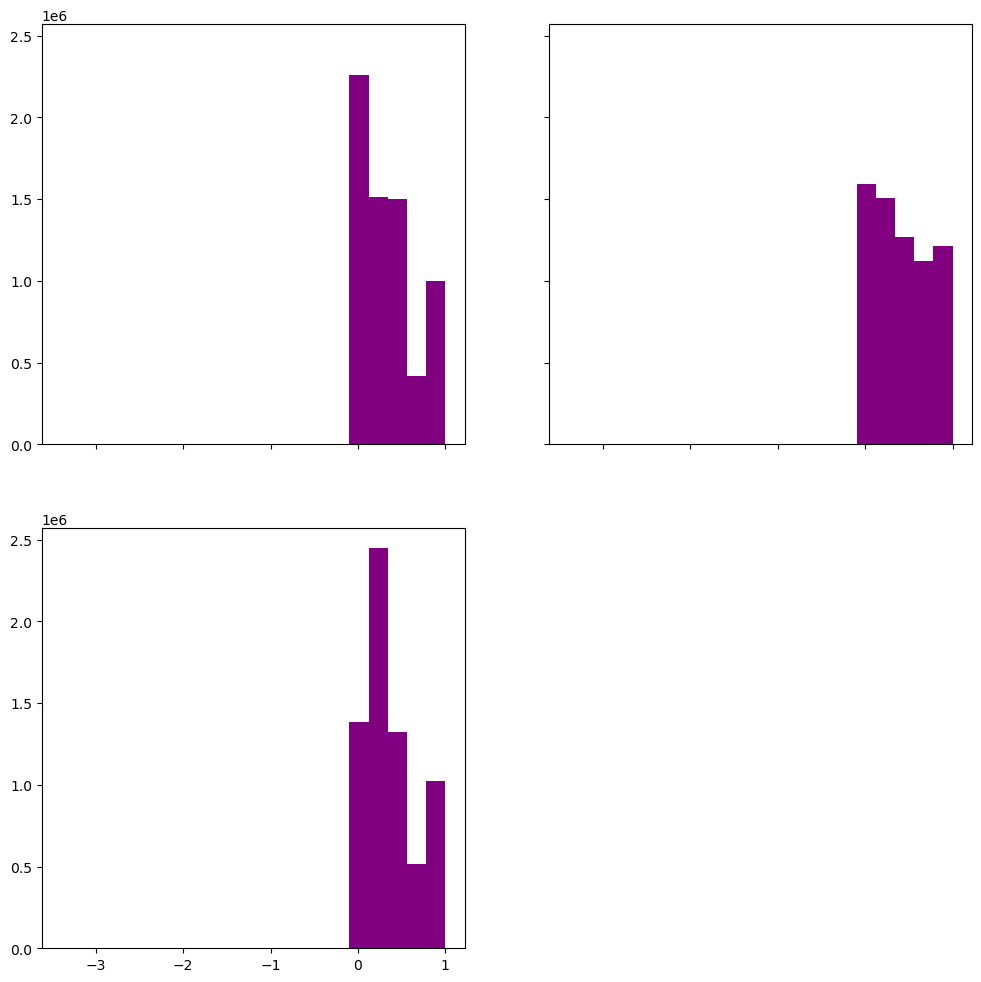

In [25]:
import earthpy.plot as ep

stretch = histogram_stretch(scaled_stack[[3,2,1],...], min_vals = 1, max_vals = 90)

ep.hist(stretch)